## MONICA Crop Model

--------------

Задачи:

* Отрисовать погоду для 2016 и 2017 годов 

* Отрисовать динамику биомассы ✅

* Сделать GA для статьи? 

* Отобразить динамику почвенных условий ✅

* Для всех рядов посчитать метрики

In [1]:
import os, sys
import json
import pandas as pd
import numpy as np 
import datetime as dt
import subprocess
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

 ## 1. Save weather in proper format for MONICA

In [2]:
def weather_to_monica(src: str, dst: str, 
                      use_real_precip: bool = False,
                      correct_precip:bool=False,
                      use_history:bool=False,
                      reanalysis: str = '../monica/reanalysis.csv'): 
    weather = pd.read_csv(src)
    
    if use_real_precip: 
        era5 = pd.read_csv(reanalysis)
        if len(era5)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = era5.loc[:, 'precip'].copy()
        
    if use_history:
        hist = pd.read_csv('../monica/baseline_monica.csv')
        print('use hist')
        if len(hist)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = hist.loc[:, 'precip'].copy()
        
        
    weather.loc[:, 'de-date'] = pd.to_datetime(weather['de-date'], format="%d.%m.%Y")
    mask = weather['de-date']<'31.12.2017'
    weather = weather.loc[mask]
    weather['de-date'] = pd.to_datetime(weather['de-date']).dt.strftime('%d.%m.%Y')
    mask = weather['relhumid']>100
    weather.loc[mask, 'relhumid']=99.99
    if correct_precip:
        mask = weather['de-date']>'2017-01-01'
        sum_precip = weather.loc[mask, 'precip'].sum()
        print('sum_precip',sum_precip)
        diff = 633 - sum_precip - 90
        to_add = diff/80
        index_to_add = weather.sample(frac=0.25).index
        weather.loc[index_to_add, 'precip'] = weather.loc[index_to_add, 'precip']+ to_add
        print(weather.iloc[-365:, :]['precip'].sum())
    weather.round(2).to_csv(dst, sep=';', index=False)
    return weather

## 2. Run MONICA model 

In [25]:
df_r = pd.read_csv('../monica/reanalysis_2016.csv')

df_m = pd.read_csv('../monica/means_2016.csv')

df_s = pd.read_csv('../monica/sarimax_2016.csv')

df_p = pd.read_csv('../monica/prophet_2016.csv')

df_np = pd.read_csv('../monica/neural_prophet_2016.csv')

df_mp = pd.read_csv('../monica/multi-prophet_2016.csv')

In [26]:
def run_monica(climate_fname: str, 
               crop: str = 'sugar-beet',
               kind:str = 'ERA5', 
               use_real_precip:bool=False, 
               correct_precip:bool=False,
              use_history:bool=False)->pd.DataFrame:
    """
    run monica model 
    
    climate_fname: str - path to file with weather
    """
    if crop=='soyabean':
        path_sim_file = '/home/monica/monica_input/soyabean-sim.json'
    elif crop == 'sugar-beet':
        path_sim_file = '/home/monica/monica_input/sugarbeat-sim.json'
    else: 

        raise KeyError(f'crop should be sugar-beet or soyabean, but your is: {crop}')

    path_monica = '../monica/monica_input/'
    dst = os.path.join(path_monica, "climate-monica.csv")
    
    weather = weather_to_monica(src=climate_fname,
                                dst=dst, 
                                use_real_precip=use_real_precip,
                                correct_precip = correct_precip,
                                use_history=use_history)

    weather.loc[:, 'weather'] = kind
    weather['de-date'] = pd.to_datetime(weather['de-date'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y' )))
    cmd = 'monica-run'
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
    print(res_monica_run)
    daily_monica = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    daily_monica.loc[:, 'weather'] = kind
    return daily_monica, weather

In [27]:
df_r, w_r = run_monica(climate_fname='../monica/reanalysis_2016.csv', crop='sugar-beet', kind='era5')

df_b, w_b = run_monica(climate_fname='../monica/means_2016.csv', crop='soyabean', kind='baseline')

df_s, w_s = run_monica(climate_fname='../monica/sarimax_2016.csv', crop='soyabean', kind='sarimax')

df_p, w_p = run_monica(climate_fname='../monica/prophet_2016.csv', crop='soyabean', kind='prophet')

df_np, w_np = run_monica(climate_fname='../monica/neural_prophet_2016.csv', crop='soyabean', kind='neural_prophet')

df_mp, w_mp = run_monica(climate_fname='../monica/multi-prophet_2016.csv', crop='soyabean', kind='multi_prophet')

df_n, w_n = run_monica(climate_fname='../monica/prophet_2016.csv', crop='soyabean', kind='prophet_corr', correct_precip=True)

CompletedProcess(args=['monica-run', '/home/monica/monica_input/sugarbeat-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
sum_precip 149.60289125605905
884.0068461588419
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)


# 3. Plots and analytics

In [10]:
!pip -q install SciencePlots

In [11]:
import scienceplots

In [12]:
plt.style.use(['science', 'no-latex'])

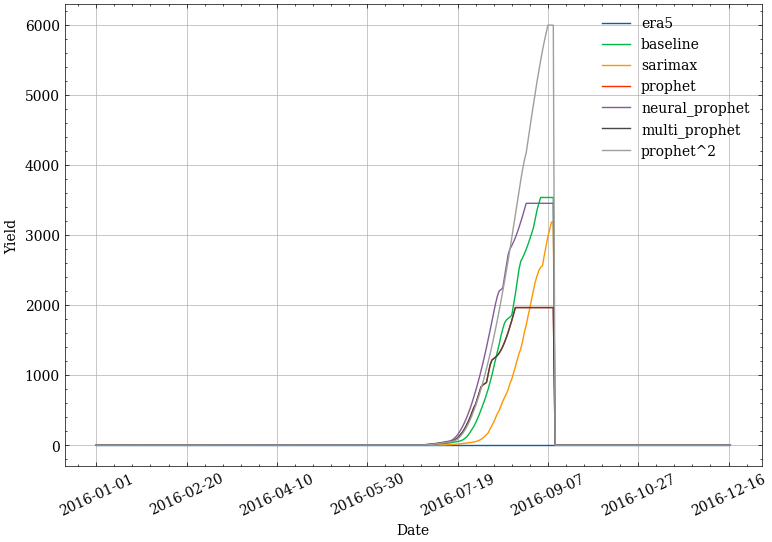

In [28]:
var = 'Yield'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
df_n.set_index('Date')[var].plot(label='prophet^2')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

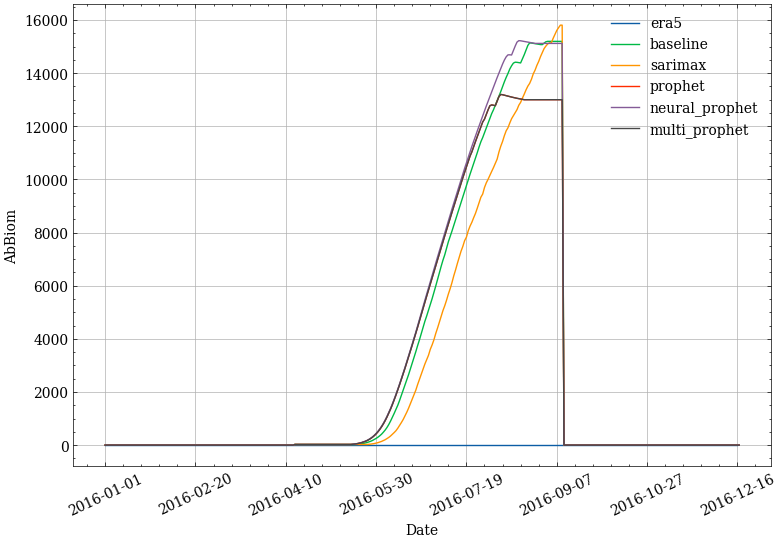

In [29]:
var = 'AbBiom'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

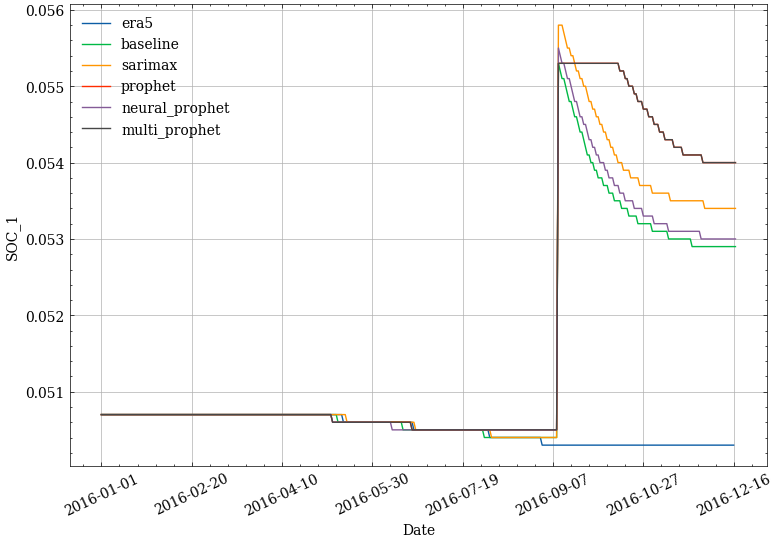

In [30]:
var = 'SOC_1'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

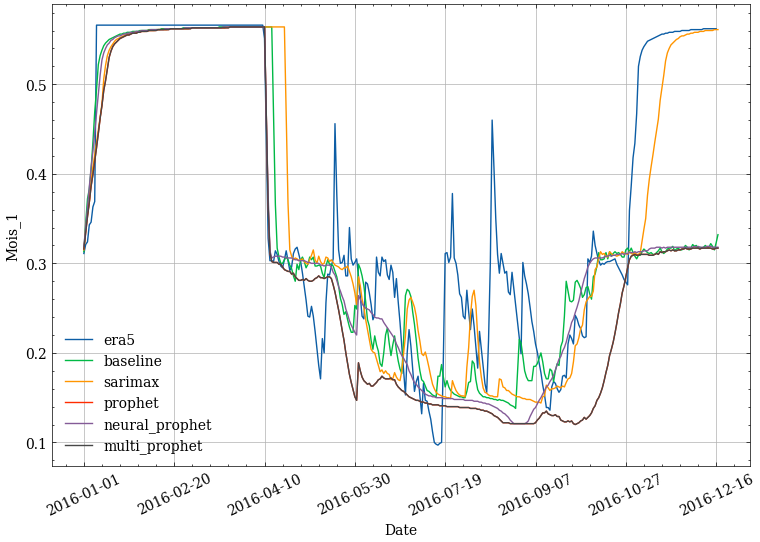

In [32]:
var = 'Mois_1'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

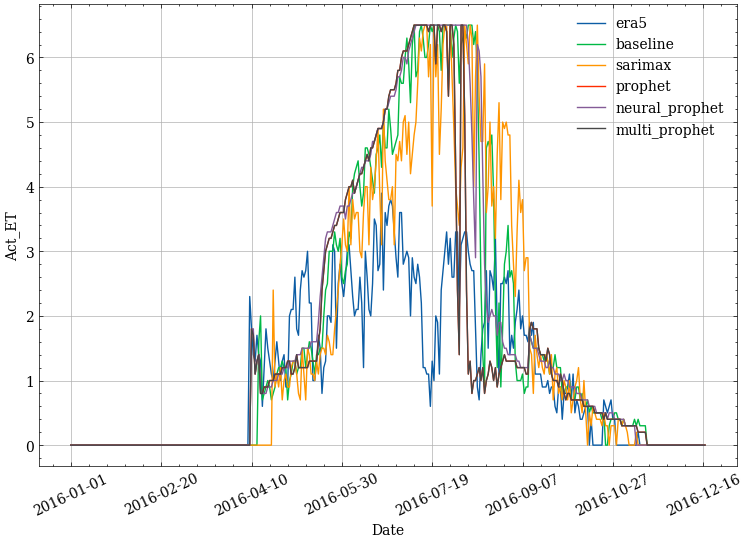

In [33]:
var = 'Act_ET'
fig, ax = plt.subplots(1,1,figsize = (9,6))
df_r.set_index('Date')[var].plot(label='era5')
df_b.set_index('Date')[var].plot(label='baseline')
df_s.set_index('Date')[var].plot(label='sarimax')
df_p.set_index('Date')[var].plot(label='prophet')
df_np.set_index('Date')[var].plot(label='neural_prophet')
df_mp.set_index('Date')[var].plot(label='multi_prophet')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

In [23]:
res_r_16 = df_r[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_b_16 = df_b[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_s_16 = df_s[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_p_16 = df_p[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_np_16 = df_np[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_mp_16 = df_mp[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()

In [34]:
res_r_2016 = df_r[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_b_2016 = df_b[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_s_2016 = df_s[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_p_2016 = df_p[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_np_2016 = df_np[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()
res_mp_2016 = df_mp[['AbBiom', 'SOC_1', 'Yield', 'Mois_1', 'Act_ET', 'NLeach', 'NO3_1', 'NH4_1']].copy()

# Metrics 2016

In [36]:
! pip -q install tslearn

In [40]:
res_r_2016.shape, res_b_2016.shape, res_s_2016.shape, res_p_2016.shape, res_np_2016.shape, res_mp_2016.shape

((351, 8), (352, 8), (352, 8), (352, 8), (352, 8), (352, 8))

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
from tslearn.metrics import dtw

def relative_rmse(target, preds):
    rmse = mean_squared_error(target, preds, squared=False)
    avg = np.full(len(preds), preds.mean())
    const_rmse = mean_squared_error(target, avg, squared=False)
    return round(rmse / const_rmse, 2)

/usr/local/lib/python3.7/dist-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [38]:
# AbBiom

In [43]:
print("Mean\t\t", mean_squared_error(res_r_2016['AbBiom'], res_b_2016['AbBiom'][:-1]))
print("Sarimax\t\t", mean_squared_error(res_r_2016['AbBiom'], res_s_2016['AbBiom'][:-1]))
print("Prophet\t\t", mean_squared_error(res_r_2016['AbBiom'], res_p_2016['AbBiom'][:-1]))
print("Neural Prophet\t", mean_squared_error(res_r_2016['AbBiom'], res_np_2016['AbBiom'][:-1]))
print("Multi Prophet\t", mean_squared_error(res_r_2016['AbBiom'], res_mp_2016['AbBiom'][:-1]))

Mean		 32841210.223646723
Sarimax		 26060660.04378917
Prophet		 29591876.206353277
Neural Prophet	 35758259.74287749
Multi Prophet	 29591876.206353277


In [45]:
print("Mean\t\t", relative_rmse(res_r_2016['AbBiom'], res_b_2016['AbBiom'][:-1]))
print("Sarimax\t\t", relative_rmse(res_r_2016['AbBiom'], res_s_2016['AbBiom'][:-1]))
print("Prophet\t\t", relative_rmse(res_r_2016['AbBiom'], res_p_2016['AbBiom'][:-1]))
print("Neural Prophet\t", relative_rmse(res_r_2016['AbBiom'], res_np_2016['AbBiom'][:-1]))
print("Multi Prophet\t", relative_rmse(res_r_2016['AbBiom'], res_mp_2016['AbBiom'][:-1]))

Mean		 2.11
Sarimax		 2.21
Prophet		 2.04
Neural Prophet	 2.07
Multi Prophet	 2.04


In [44]:
print("Mean\t\t", r2_score(res_r_2016['AbBiom'], res_b_2016['AbBiom'][:-1]))
print("Sarimax\t\t", r2_score(res_r_2016['AbBiom'], res_s_2016['AbBiom'][:-1]))
print("Prophet\t\t", r2_score(res_r_2016['AbBiom'], res_p_2016['AbBiom'][:-1]))
print("Neural Prophet\t", r2_score(res_r_2016['AbBiom'], res_np_2016['AbBiom'][:-1]))
print("Multi Prophet\t", r2_score(res_r_2016['AbBiom'], res_mp_2016['AbBiom'][:-1]))

Mean		 0.0
Sarimax		 0.0
Prophet		 0.0
Neural Prophet	 0.0
Multi Prophet	 0.0


In [50]:
print("Mean\t\t", dtw(res_r_2016['AbBiom'], res_b_2016['AbBiom'][:-1]))
print("Sarimax\t\t", dtw(res_r_2016['AbBiom'], res_s_2016['AbBiom'][:-1]))
print("Prophet\t\t", dtw(res_r_2016['AbBiom'], res_p_2016['AbBiom'][:-1]))
print("Neural Prophet\t", dtw(res_r_2016['AbBiom'], res_np_2016['AbBiom'][:-1]))
print("Multi Prophet\t", dtw(res_r_2016['AbBiom'], res_mp_2016['AbBiom'][:-1]))

Mean		 107365.10042141253
Sarimax		 95641.47466120543
Prophet		 101915.39897596437
Neural Prophet	 112031.9113902374
Multi Prophet	 101915.39897596437


In [51]:
# SOC_1

In [52]:
print("Mean\t\t", mean_squared_error(res_r_2016['SOC_1'], res_b_2016['SOC_1'][:-1]))
print("Sarimax\t\t", mean_squared_error(res_r_2016['SOC_1'], res_s_2016['SOC_1'][:-1]))
print("Prophet\t\t", mean_squared_error(res_r_2016['SOC_1'], res_p_2016['SOC_1'][:-1]))
print("Neural Prophet\t", mean_squared_error(res_r_2016['SOC_1'], res_np_2016['SOC_1'][:-1]))
print("Multi Prophet\t", mean_squared_error(res_r_2016['SOC_1'], res_mp_2016['SOC_1'][:-1]))

Mean		 2.915641025641032e-06
Sarimax		 4.036980056980062e-06
Prophet		 5.459772079772088e-06
Neural Prophet	 3.215669515669522e-06
Multi Prophet	 5.459772079772088e-06


In [53]:
print("Mean\t\t", relative_rmse(res_r_2016['SOC_1'], res_b_2016['SOC_1'][:-1]))
print("Sarimax\t\t", relative_rmse(res_r_2016['SOC_1'], res_s_2016['SOC_1'][:-1]))
print("Prophet\t\t", relative_rmse(res_r_2016['SOC_1'], res_p_2016['SOC_1'][:-1]))
print("Neural Prophet\t", relative_rmse(res_r_2016['SOC_1'], res_np_2016['SOC_1'][:-1]))
print("Multi Prophet\t", relative_rmse(res_r_2016['SOC_1'], res_mp_2016['SOC_1'][:-1]))

Mean		 1.9
Sarimax		 1.9
Prophet		 1.87
Neural Prophet	 1.89
Multi Prophet	 1.87


In [54]:
print("Mean\t\t", r2_score(res_r_2016['SOC_1'], res_b_2016['SOC_1'][:-1]))
print("Sarimax\t\t", r2_score(res_r_2016['SOC_1'], res_s_2016['SOC_1'][:-1]))
print("Prophet\t\t", r2_score(res_r_2016['SOC_1'], res_p_2016['SOC_1'][:-1]))
print("Neural Prophet\t", r2_score(res_r_2016['SOC_1'], res_np_2016['SOC_1'][:-1]))
print("Multi Prophet\t", r2_score(res_r_2016['SOC_1'], res_mp_2016['SOC_1'][:-1]))

Mean		 -99.29985536220701
Sarimax		 -137.8746118792835
Prophet		 -186.81953782920112
Neural Prophet	 -109.62102106462152
Multi Prophet	 -186.81953782920112


In [55]:
print("Mean\t\t", dtw(res_r_2016['SOC_1'], res_b_2016['SOC_1'][:-1]))
print("Sarimax\t\t", dtw(res_r_2016['SOC_1'], res_s_2016['SOC_1'][:-1]))
print("Prophet\t\t", dtw(res_r_2016['SOC_1'], res_p_2016['SOC_1'][:-1]))
print("Neural Prophet\t", dtw(res_r_2016['SOC_1'], res_np_2016['SOC_1'][:-1]))
print("Multi Prophet\t", dtw(res_r_2016['SOC_1'], res_mp_2016['SOC_1'][:-1]))

Mean		 0.031988591716422946
Sarimax		 0.03764226348135826
Prophet		 0.04377567817864167
Neural Prophet	 0.03359345174286209
Multi Prophet	 0.04377567817864167


In [56]:
# Yield

In [57]:
print("Mean\t\t", mean_squared_error(res_r_2016['Yield'], res_b_2016['Yield'][:-1]))
print("Sarimax\t\t", mean_squared_error(res_r_2016['Yield'], res_s_2016['Yield'][:-1]))
print("Prophet\t\t", mean_squared_error(res_r_2016['Yield'], res_p_2016['Yield'][:-1]))
print("Neural Prophet\t", mean_squared_error(res_r_2016['Yield'], res_np_2016['Yield'][:-1]))
print("Multi Prophet\t", mean_squared_error(res_r_2016['Yield'], res_mp_2016['Yield'][:-1]))

Mean		 717206.9680911681
Sarimax		 344824.8241310541
Prophet		 344741.89675213676
Neural Prophet	 968590.949031339
Multi Prophet	 344741.89675213676


In [58]:
print("Mean\t\t", relative_rmse(res_r_2016['Yield'], res_b_2016['Yield'][:-1]))
print("Sarimax\t\t", relative_rmse(res_r_2016['Yield'], res_s_2016['Yield'][:-1]))
print("Prophet\t\t", relative_rmse(res_r_2016['Yield'], res_p_2016['Yield'][:-1]))
print("Neural Prophet\t", relative_rmse(res_r_2016['Yield'], res_np_2016['Yield'][:-1]))
print("Multi Prophet\t", relative_rmse(res_r_2016['Yield'], res_mp_2016['Yield'][:-1]))

Mean		 3.12
Sarimax		 3.57
Prophet		 2.81
Neural Prophet	 2.88
Multi Prophet	 2.81


In [59]:
print("Mean\t\t", r2_score(res_r_2016['Yield'], res_b_2016['Yield'][:-1]))
print("Sarimax\t\t", r2_score(res_r_2016['Yield'], res_s_2016['Yield'][:-1]))
print("Prophet\t\t", r2_score(res_r_2016['Yield'], res_p_2016['Yield'][:-1]))
print("Neural Prophet\t", r2_score(res_r_2016['Yield'], res_np_2016['Yield'][:-1]))
print("Multi Prophet\t", r2_score(res_r_2016['Yield'], res_mp_2016['Yield'][:-1]))

Mean		 0.0
Sarimax		 0.0
Prophet		 0.0
Neural Prophet	 0.0
Multi Prophet	 0.0


In [60]:
print("Mean\t\t", dtw(res_r_2016['Yield'], res_b_2016['Yield'][:-1]))
print("Sarimax\t\t", dtw(res_r_2016['Yield'], res_s_2016['Yield'][:-1]))
print("Prophet\t\t", dtw(res_r_2016['Yield'], res_p_2016['Yield'][:-1]))
print("Neural Prophet\t", dtw(res_r_2016['Yield'], res_np_2016['Yield'][:-1]))
print("Multi Prophet\t", dtw(res_r_2016['Yield'], res_mp_2016['Yield'][:-1]))

Mean		 15866.305360732222
Sarimax		 11001.523224990256
Prophet		 11000.200259995268
Neural Prophet	 18438.422468042103
Multi Prophet	 11000.200259995268
